### <span style='color:#ff5f27'> Imports

In [188]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import hopsworks

import warnings
warnings.filterwarnings("ignore")

# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

In [189]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip any parent directories to add the root_dir to the PYTHON_PATH 
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('fingrid',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Added the following directory to the PYTHONPATH: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book
HopsworksSettings initialized!


## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [190]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store()

2026-01-10 14:09:37,754 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-10 14:09:37,765 INFO: Initializing external client
2026-01-10 14:09:37,766 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-10 14:09:39,341 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286359


In [191]:
# Retrieve feature groups
energy_fg = fs.get_feature_group(
    name='energy_consumption',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_finland',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> Feature View Creation and Retrieving </span>

In [192]:
# Select features for training data (no lag features - matching inference)
selected_features = energy_fg.select([
    'consumption_mw', 'date',
    'year', 'month', 'day', 'hour',
    'day_of_week', 'is_weekend', 'week_of_year'
]).join(weather_fg.select_features(), on=['country'])

print("Selected features: temporal + weather (no lags)")

2026-01-10 14:09:41,439 INFO: Using ['temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation'] from feature group `weather_finland` as features for the query. To include primary key and event time use `select_all`.
Selected features: temporal + weather (no lags)


In [193]:
feature_view = fs.get_or_create_feature_view(
    name='energy_consumption_fv',
    description="Temporal and weather features with energy consumption as target (no lag features)",
    version=1,  # Increment version since features changed
    labels=['consumption_mw'],
    query=selected_features,
)

## <span style="color:#ff5f27;">Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [194]:
# Test on September 2025 data, train on all other data
# Filter feature view to get all available data, then split by September month

# Read data from feature view efficiently
all_data = feature_view.query.read()

# Convert to pandas if needed
if not isinstance(all_data, pd.DataFrame):
    all_data = all_data.toPandas()

# Split by month and year: September 2025 for testing, all other data for training
test_month = 9
test_year = 2025
test_data = all_data[(all_data['month'] == test_month) & (all_data['year'] == test_year)].copy().sort_values('date').reset_index(drop=True)
train_data = all_data[~((all_data['month'] == test_month) & (all_data['year'] == test_year))].copy().sort_values('date').reset_index(drop=True)

print(f"Training on all data except September 2025: {len(train_data)} samples")
print(f"Testing on September 2025 data: {len(test_data)} samples")
print(f"\nTest set date range:")
if len(test_data) > 0:
    print(f"  Start: {test_data['date'].min()}")
    print(f"  End: {test_data['date'].max()}")


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.61s) 
Training on all data except September 2025: 370125 samples
Testing on September 2025 data: 14394 samples

Test set date range:
  Start: 2025-09-01 00:00:00+00:00
  End: 2025-09-30 23:57:00+00:00


In [195]:

# Convert dates to datetime
test_data['date'] = pd.to_datetime(test_data['date'])
train_data['date'] = pd.to_datetime(train_data['date'])

print(f"Data preparation complete")
print(f"Weekends in test data: {test_data['is_weekend'].sum()}")


Data preparation complete
Weekends in test data: 3840


In [196]:
# Prepare X and y for train and test sets
X_train = train_data.drop(columns=['consumption_mw'])
y_train = train_data[['consumption_mw']]

X_test = test_data.drop(columns=['consumption_mw'])
y_test = test_data[['consumption_mw']]


In [197]:
X_train

,date,year,month,day,hour,day_of_week,is_weekend,week_of_year,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation
0,2024-01-02 20:43:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0
1,2024-01-02 20:46:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0
2,2024-01-02 20:49:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0
3,2024-01-02 20:52:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0
4,2024-01-02 20:55:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370120,2026-01-10 06:09:00+00:00,2026,1,10,6,5,1,2,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.0
370121,2026-01-10 06:12:00+00:00,2026,1,10,6,5,1,2,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.0
370122,2026-01-10 06:15:00+00:00,2026,1,10,6,5,1,2,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.0
370123,2026-01-10 06:18:00+00:00,2026,1,10,6,5,1,2,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.0


In [198]:
y_train

,consumption_mw
0,14400.0
1,14366.0
2,14331.0
3,14277.0
4,14385.0
...,...
370120,14153.0
370121,14244.0
370122,14283.0
370123,14240.0


In [199]:
# Drop date column if it exists
columns_to_drop = [col for col in ['date', 'country'] if col in X_train.columns]
X_features = X_train.drop(columns=columns_to_drop)
X_test_features = X_test.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining features: {list(X_features.columns)}")

Dropped columns: ['date']
Remaining features: ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation']


## <span style="color:#ff5f27;">Modeling</span>

We will train a regression model to predict energy consumption using our weather and temporal features

In [200]:
# Handle any missing values by filling with forward fill then backward fill
X_features = X_features.ffill().bfill()
X_test_features = X_test_features.ffill().bfill()

# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    random_state=42
)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [201]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating metrics
mae = mean_absolute_error(y_test.iloc[:,0], y_pred)
print("MAE:", mae)

mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R²:", r2)

MAE: 269.11254221322685
MSE: 118925.81424056644
RMSE: 344.8562225632103
R²: 0.7127390371723972


In [202]:
# Create dataframe with predictions and dates
df = y_test.copy()
df['predicted_consumption'] = y_pred
df['date'] = X_test['date'].values
df = df.sort_values(by=['date'])
df.head()

,consumption_mw,predicted_consumption,date
0,7202.0,7515.870605,2025-09-01 00:00:00
1,7257.4,7515.870605,2025-09-01 00:03:00
2,7224.2,7515.870605,2025-09-01 00:06:00
3,7220.5,7515.870605,2025-09-01 00:09:00
4,7206.4,7515.870605,2025-09-01 00:12:00


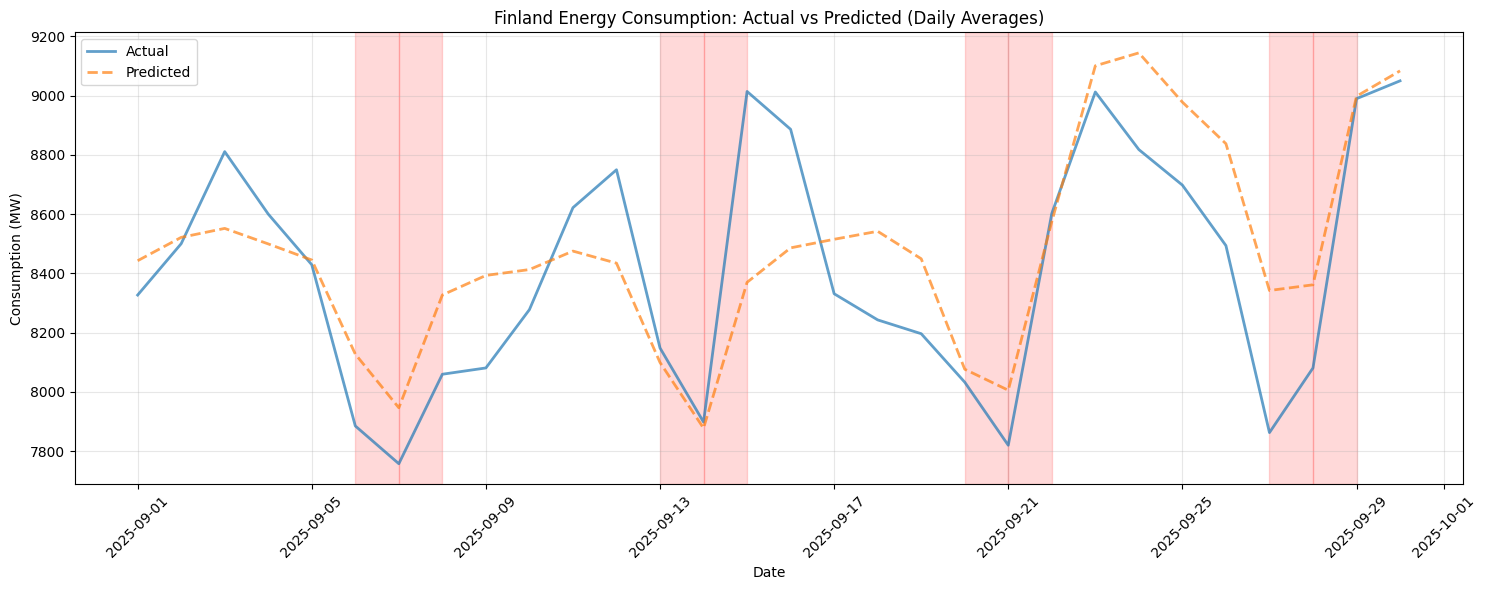

Original samples: 14394, Daily averages shown: 30
Plot saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/docs/fingrid/assets/img/energy_consumption_predictions.png
(Pale red background indicates weekends)


In [203]:
# Plot predictions vs actual (resampled to daily averages for clarity)
# Resample to daily averages to make the plot readable
df['date'] = pd.to_datetime(df['date'])
df_daily = df.set_index('date').resample('D').mean().reset_index()

# Add weekend flag to daily data
df_daily['is_weekend'] = df_daily['date'].dt.dayofweek >= 5  # Saturday=5, Sunday=6

plt.figure(figsize=(15, 6))

# Highlight weekends with pale red background
for i in range(len(df_daily) - 1):
    if df_daily.iloc[i]['is_weekend']:
        plt.axvspan(df_daily.iloc[i]['date'], df_daily.iloc[i+1]['date'], 
                    alpha=0.15, color='red', zorder=0)

plt.plot(df_daily['date'], df_daily['consumption_mw'], label='Actual', linewidth=2, alpha=0.7)
plt.plot(df_daily['date'], df_daily['predicted_consumption'], label='Predicted', linewidth=2, alpha=0.7, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.title('Finland Energy Consumption: Actual vs Predicted (Daily Averages)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plot_path = f"{root_dir}/docs/fingrid/assets/img/energy_consumption_predictions.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Original samples: {len(df)}, Daily averages shown: {len(df_daily)}")
print(f"Plot saved to: {plot_path}")
print(f"(Pale red background indicates weekends)")


In [204]:
# Investigate the drop between samples 6000-8000
print(f"Total test samples: {len(y_test)}")
print(f"\nTest set date range:")
print(f"  Start: {X_test['date'].min()}")
print(f"  End: {X_test['date'].max()}")

if len(y_test) > 8000:
    print(f"\nDates around the drop (samples 5900-6100):")
    print(X_test.iloc[5900:6100:20][['date']])
    
    print(f"\nDates around sample 7000:")
    print(X_test.iloc[6900:7100:20][['date']])
    
    print(f"\nConsumption values around the drop:")
    print(f"  Sample 6000: {y_test.iloc[6000, 0]:.2f} MW")
    print(f"  Sample 7000: {y_test.iloc[7000, 0]:.2f} MW")
    print(f"  Sample 8000: {y_test.iloc[8000, 0]:.2f} MW")
else:
    print(f"\nTest set only has {len(y_test)} samples, not 8000+")
    print("The drop you're seeing might be in the full dataset visualization")

Total test samples: 14394

Test set date range:
  Start: 2025-09-01 00:00:00+00:00
  End: 2025-09-30 23:57:00+00:00

Dates around the drop (samples 5900-6100):
                          date
5900 2025-09-13 07:06:00+00:00
5920 2025-09-13 08:06:00+00:00
5940 2025-09-13 09:06:00+00:00
5960 2025-09-13 10:06:00+00:00
5980 2025-09-13 11:06:00+00:00
6000 2025-09-13 12:06:00+00:00
6020 2025-09-13 13:06:00+00:00
6040 2025-09-13 14:06:00+00:00
6060 2025-09-13 15:06:00+00:00
6080 2025-09-13 16:06:00+00:00

Dates around sample 7000:
                          date
6900 2025-09-15 09:06:00+00:00
6920 2025-09-15 10:06:00+00:00
6940 2025-09-15 11:06:00+00:00
6960 2025-09-15 12:06:00+00:00
6980 2025-09-15 13:06:00+00:00
7000 2025-09-15 14:06:00+00:00
7020 2025-09-15 15:06:00+00:00
7040 2025-09-15 16:06:00+00:00
7060 2025-09-15 17:06:00+00:00
7080 2025-09-15 18:06:00+00:00

Consumption values around the drop:
  Sample 6000: 8324.00 MW
  Sample 7000: 9514.30 MW
  Sample 8000: 8360.20 MW


In [205]:

# Detailed analysis of test set performance
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values('date')

# Get first and last week of test set
first_week = df_sorted[df_sorted['date'] < df_sorted['date'].min() + pd.Timedelta(days=7)]
last_week = df_sorted[df_sorted['date'] >= df_sorted['date'].max() - pd.Timedelta(days=7)]

print("Test Set Performance Analysis:")
print("=" * 80)

print(f"\nFirst week of test set ({first_week['date'].min().date()} to {first_week['date'].max().date()}):")
if len(first_week) > 0:
    print(f"  MAE: {mean_absolute_error(first_week['consumption_mw'], first_week['predicted_consumption']):.0f} MW")
    print(f"  Mean error: {(first_week['consumption_mw'] - first_week['predicted_consumption']).mean():.0f} MW")

print(f"\nLast week of test set ({last_week['date'].min().date()} to {last_week['date'].max().date()}):")
if len(last_week) > 0:
    print(f"  MAE: {mean_absolute_error(last_week['consumption_mw'], last_week['predicted_consumption']):.0f} MW")
    print(f"  Mean error: {(last_week['consumption_mw'] - last_week['predicted_consumption']).mean():.0f} MW")

# Sample some predictions
print("\nSample predictions (last 10 timestamps):")
print(df_sorted[['date', 'consumption_mw', 'predicted_consumption']].tail(10))


Test Set Performance Analysis:

First week of test set (2025-09-01 to 2025-09-07):
  MAE: 214 MW
  Mean error: -32 MW

Last week of test set (2025-09-23 to 2025-09-30):
  MAE: 342 MW
  Mean error: -250 MW

Sample predictions (last 10 timestamps):
                     date  consumption_mw  predicted_consumption
14384 2025-09-30 23:30:00          8614.7            8912.249023
14385 2025-09-30 23:33:00          8572.0            8912.249023
14386 2025-09-30 23:36:00          8486.7            8912.249023
14387 2025-09-30 23:39:00          8487.5            8912.249023
14388 2025-09-30 23:42:00          8543.8            8912.249023
14389 2025-09-30 23:45:00          8566.3            8912.249023
14390 2025-09-30 23:48:00          8543.0            8912.249023
14391 2025-09-30 23:51:00          8532.6            8912.249023
14392 2025-09-30 23:54:00          8514.5            8912.249023
14393 2025-09-30 23:57:00          8511.3            8912.249023


In [206]:
# Check what features look like around New Year's
X_test_with_date = X_test.copy()
X_test_with_date['predicted'] = y_pred
X_test_with_date['actual'] = y_test.values

# Filter for New Year's period
new_years_features = X_test_with_date[X_test_with_date['date'] >= '2025-12-28'].sort_values('date')

print("Feature values during the prediction failure:")
print("=" * 80)
print("\nTemporal features:")
print(new_years_features[['date', 'month', 'day', 'hour', 'day_of_week', 'is_weekend']].describe())

# Check if weather features exist and show them
weather_cols = [col for col in new_years_features.columns if any(w in col.lower() for w in ['temp', 'wind', 'precip', 'pressure'])]
if weather_cols:
    print("\nWeather features statistics:")
    print(new_years_features[weather_cols].describe())
    
print("\nFirst few rows of New Year's period:")
display_cols = ['date', 'hour', 'day', 'actual', 'predicted'] + weather_cols[:3]
print(new_years_features[display_cols].head(20))

Feature values during the prediction failure:

Temporal features:
       month  day  hour  day_of_week  is_weekend
count    0.0  0.0   0.0          0.0         0.0
mean     NaN  NaN   NaN          NaN         NaN
std      NaN  NaN   NaN          NaN         NaN
min      NaN  NaN   NaN          NaN         NaN
25%      NaN  NaN   NaN          NaN         NaN
50%      NaN  NaN   NaN          NaN         NaN
75%      NaN  NaN   NaN          NaN         NaN
max      NaN  NaN   NaN          NaN         NaN

Weather features statistics:
       temperature_2m  precipitation  wind_speed_10m  wind_speed_100m  \
count             0.0            0.0             0.0              0.0   
mean              NaN            NaN             NaN              NaN   
std               NaN            NaN             NaN              NaN   
min               NaN            NaN             NaN              NaN   
25%               NaN            NaN             NaN              NaN   
50%               NaN    

---

## <span style="color:#ff5f27;">Feature Importance Analysis</span>

In [207]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_features.columns,
    'importance': xgb_regressor.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
feature_importance.head(15)

Top 15 Most Important Features:


,feature,importance
7,temperature_2m,0.605659
6,week_of_year,0.157273
14,shortwave_radiation,0.060292
0,year,0.047091
1,month,0.031145
4,day_of_week,0.023129
10,wind_speed_10m,0.015861
3,hour,0.015551
2,day,0.012805
13,surface_pressure,0.008885


In [208]:
# Check correlation between features and target (using cleaned features)
correlations = X_features.corrwith(y_train.iloc[:, 0]).abs().sort_values(ascending=False)
print("Top 20 features by correlation with consumption:")
print(correlations.head(20))

Top 20 features by correlation with consumption:
temperature_2m         0.817731
week_of_year           0.343757
month                  0.315003
shortwave_radiation    0.277301
cloud_cover            0.266584
wind_speed_100m        0.240101
wind_speed_10m         0.229859
is_weekend             0.105487
year                   0.082573
day_of_week            0.076085
wind_direction_10m     0.066650
day                    0.063252
surface_pressure       0.058877
hour                   0.047170
precipitation          0.013597
dtype: float64


In [209]:
# Check all features and their importance
print("All features in the model:")
print(feature_importance)
print(f"\nTotal features: {len(feature_importance)}")

# Identify weather features (assuming they contain 'temp', 'wind', 'precip', 'pressure', 'humidity')
weather_keywords = ['temp', 'wind', 'precip', 'pressure', 'humidity', 'weather']
weather_features = feature_importance[feature_importance['feature'].str.contains('|'.join(weather_keywords), case=False)]
print(f"\nWeather features found: {len(weather_features)}")
if len(weather_features) > 0:
    print("\nWeather feature importance:")
    print(weather_features)

All features in the model:
                feature  importance
7        temperature_2m    0.605659
6          week_of_year    0.157273
14  shortwave_radiation    0.060292
0                  year    0.047091
1                 month    0.031145
4           day_of_week    0.023129
10       wind_speed_10m    0.015861
3                  hour    0.015551
2                   day    0.012805
13     surface_pressure    0.008885
11      wind_speed_100m    0.007101
12   wind_direction_10m    0.005607
8         precipitation    0.005134
9           cloud_cover    0.004467
5            is_weekend    0.000000

Total features: 15

Weather features found: 6

Weather feature importance:
               feature  importance
7       temperature_2m    0.605659
10      wind_speed_10m    0.015861
13    surface_pressure    0.008885
11     wind_speed_100m    0.007101
12  wind_direction_10m    0.005607
8        precipitation    0.005134


Feature importance plot saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/docs/fingrid/assets/img/feature_importance.png


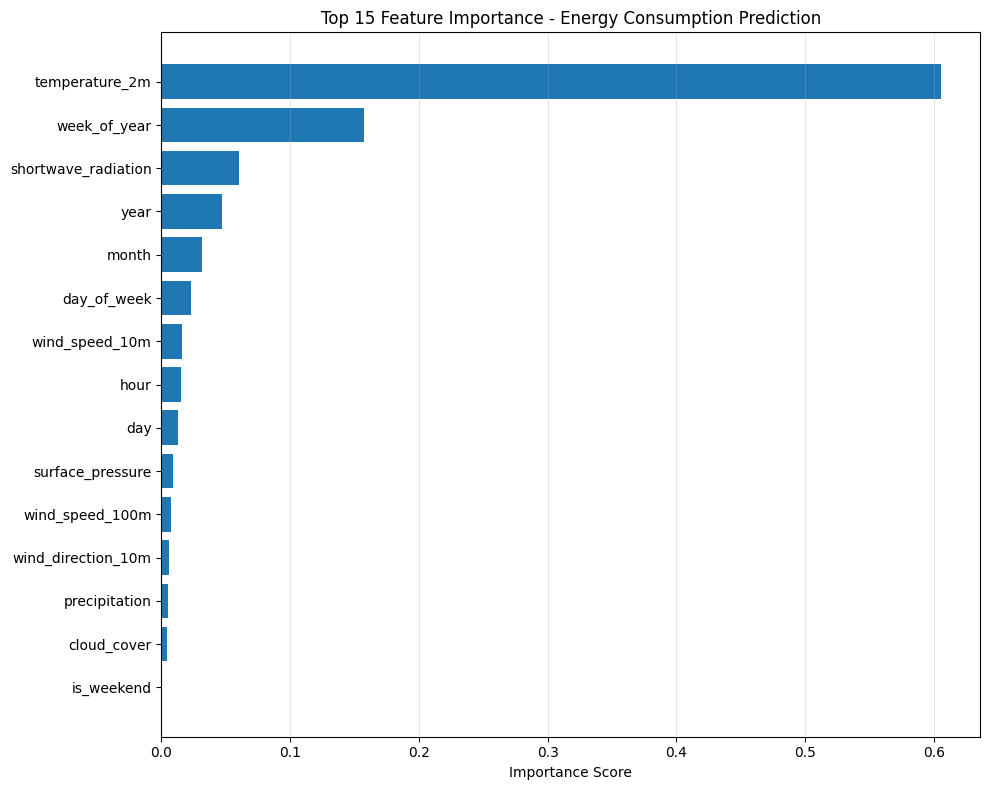

In [212]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['importance'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importance - Energy Consumption Prediction')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()

# Save feature importance plot
feature_importance_path = f"{root_dir}/docs/fingrid/assets/img/feature_importance.png"
os.makedirs(os.path.dirname(feature_importance_path), exist_ok=True)
plt.savefig(feature_importance_path, dpi=300, bbox_inches='tight')
print(f"Feature importance plot saved to: {feature_importance_path}")

plt.show()

In [ ]:
# Plot correlation with target
plt.figure(figsize=(10, 8))
top_n_corr = 15
top_correlations = correlations.head(top_n_corr)

plt.barh(range(len(top_correlations)), top_correlations.values)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Absolute Correlation with Consumption')
plt.title(f'Top {top_n_corr} Features by Correlation - Energy Consumption')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()

# Save correlation plot
correlation_path = f"{root_dir}/docs/fingrid/assets/img/feature_correlation.png"
os.makedirs(os.path.dirname(correlation_path), exist_ok=True)
plt.savefig(correlation_path, dpi=300, bbox_inches='tight')
print(f"Feature correlation plot saved to: {correlation_path}")

plt.show()

---

## <span style="color:#ff5f27;">Register Model to Hopsworks</span>

In [211]:
# Get model registry
mr = project.get_model_registry()

# Create model schema (input/output)
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Register model
energy_model = mr.python.create_model(
    name="energy_consumption_predictor",
    metrics={
        "mae": float(mae),
        "mse": float(mse),
        "rmse": float(rmse),
        "r2": float(r2)
    },
    description="XGBoost model for Finland energy consumption forecasting with weather features",
    input_example=X_train.sample(n=5),
    model_schema=model_schema
)

# Save model to fingrid/energy_model directory
import os
import joblib
model_dir = f"{root_dir}/fingrid/energy_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model_filename = f"{model_dir}/energy_consumption_predictor.pkl"
joblib.dump(xgb_regressor, model_filename)

energy_model.save(model_dir)
print(f"Model saved to: {model_filename}")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor.…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\input_example.json: 0.000%|     …

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\model_schema.json: 0.000%|      …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286359/models/energy_consumption_predictor/18
Model saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor.pkl
